In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Importing data as numpyarray

In [59]:
data=np.genfromtxt("C:/Users/joshi/Downloads/ieeedata.csv",delimiter=",")

For avoiding errors and Nan renmoving the head row

In [60]:
data=np.delete(data,0,axis=0)
display(data)

array([[3.49190737e+07, 1.85860000e+04, 8.88386219e+06, 7.07169700e+06,
        2.26225593e+03],
       [4.11907060e+05, 6.84183000e+05, 1.36779460e+01, 7.18360560e+07,
        8.36350000e+03],
       [1.72273156e+05, 5.70700000e+03, 2.15739520e+00, 5.98083600e+06,
        7.07000000e+00],
       ...,
       [1.79631000e+03, 4.80000000e+01, 6.34000000e-01, 8.00000000e+01,
        1.37322263e+08],
       [5.03505600e+06, 3.02063232e+08, 1.69713532e+04, 1.62760000e+04,
        6.03228926e-01],
       [3.67866325e+07, 8.95157255e+08, 6.73051131e+05, 5.10187058e+08,
        5.19035402e+03]])

To apply Kmeans algorithm on this dataset we first need to convert this data to a 2D dataset for the ease of visualisation.
For that we will use method called Principal Component Analysis or PCA which would return 2 components from this 5D dataset

PCA uses covariances to compare features which is sensitive to scale of data so we need to normalise the data to comparable values.
We subract the data by the mean value and divide it by the standard deviation of that column

In [61]:
standardized_data = (data - data.mean(axis = 0)) / data.std(axis = 0)

Calculating the Covariance Matrix

In [62]:
covariance_matrix = np.cov(standardized_data, ddof = 0, rowvar = False)

By using Eigendecomposition method we find how the covariances are related to each other

In [63]:
#this function will return eigenvalues and eigenfucntions
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

Eigenvectors are principal components for PCA, more important components will have higher eigenvalues.
To get right principal components, we will sort them based on their eigenvalues highest to lowest.

In [64]:
#arg sort gives lowest to highest using [::-1] we can reverse the list
order_of_importance = np.argsort(eigenvalues)[::-1] 
#using sort
sorted_eigenvalues = eigenvalues[order_of_importance]
sorted_eigenvectors = eigenvectors[:,order_of_importance]
#using the sorted eigenvalues to find explained variances corresponding to eignenvector which will return value between 0 to 1
explained_variance = sorted_eigenvalues / np.sum(sorted_eigenvalues)

We obtain the Reduced data with 2 components so now we can head to applying K means

In [65]:
k = 2 
X = np.matmul(standardized_data, sorted_eigenvectors[:,:k]) 
display(X)

array([[ 1.15690331e-01,  1.46447645e-01],
       [ 3.40717407e-02,  1.00801705e-01],
       [ 2.32359756e-01,  3.36843060e-02],
       [ 2.50399125e-01,  2.73018751e-02],
       [-3.60898186e-01,  3.67062391e-01],
       [-8.73876225e-01,  2.26472008e-01],
       [-6.68004550e-01, -1.52235737e+00],
       [-2.06168804e-02,  1.20206506e-01],
       [ 9.43998912e-03,  1.06944658e-01],
       [-2.18437580e+00,  9.06553595e-01],
       [ 1.49828806e-01, -1.43019157e-01],
       [ 2.05405851e+00,  1.88204553e+00],
       [ 8.32719313e-01,  6.35370687e-01],
       [ 4.55211956e-01,  2.39971672e-01],
       [-1.14645323e-02,  1.41365652e-01],
       [ 4.68858039e-01,  2.54129856e-01],
       [-1.66705344e+00,  9.59958578e-01],
       [ 4.49299246e-01, -4.64769088e-01],
       [ 1.13199184e-01, -1.30452106e-01],
       [ 1.81751935e-01,  6.25014837e-02],
       [-7.22726356e-01, -1.84774349e+00],
       [ 2.77485909e-01,  7.14345901e-02],
       [ 2.25629322e-01,  3.59045110e-02],
       [-9.

In [66]:
df=pd.DataFrame(X,columns=['PCA1','PCA2'])

In [67]:
df #displaying PCA data

,PCA1,PCA2
0,0.115690,0.146448
1,0.034072,0.100802
2,0.232360,0.033684
3,0.250399,0.027302
4,-0.360898,0.367062
...,...,...
495,0.249051,0.026288
496,0.253406,0.021398
497,0.629868,-0.823380
498,-0.354657,-0.945540


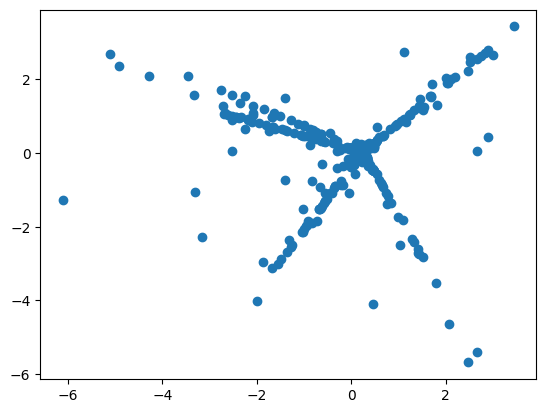

In [68]:
plt.scatter(df["PCA1"],df["PCA2"])

Now we make a function which will intialize random centroids

In [69]:
def random_centroids(K, X):
    m, n = np.shape(X)
    centroids = np.empty((K, n))
    for i in range(K):
        centroids[i] =  X[np.random.choice(range(m))] 
    return centroids

Function to find eucledian distance between two data points

In [70]:
def distance(x1, x2):
    return np.sqrt(np.sum(np.power(x1 - x2, 2)))

This function Compares distances between data points and intial centroids 

In [71]:
def nearest_centroid(x, centroids, K):
    """Finds and returns the index of the closest centroid for a given vector x"""
    distances = np.empty(K)
    for i in range(K):
        distances[i] = distance(centroids[i], x)
    return np.argmin(distances)

This function lables datapoints according to number of clusters (K) 

In [72]:
def cluster(centroids, K, X):
    """Returns an array of cluster indices for all the data samples"""
    m, _ = np.shape(X)
    cluster_idx = np.empty(m)
    for i in range(m):
        cluster_idx[i] = nearest_centroid(X[i], centroids, K)
    return cluster_idx

Computing Mean to update the cluster centroids

In [73]:
def compute_means(cluster_idx, K, X):
    
    _, n = np.shape(X)
    centroids = np.empty((K, n))
    for i in range(K):
        points = X[cluster_idx == i] # gather points for the cluster i
        centroids[i] = np.mean(points, axis=0) # use axis=0 to compute means across points
    return centroids

Finally Compiling all function to run Kmeans algorithm

In [74]:
def Kmeans(K, X, max_iterations=500):
    centroids = random_centroids(K, X)
    # loop till max_iterations or convergance
    print(f"initial centroids: {centroids}")
    for _ in range(max_iterations):
        # create clusters by assigning the samples to the closet centroids
        clusters = cluster(centroids, K, X)
        previous_centroids = centroids                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
        # compute means of the clusters and assign to centroids
        centroids = compute_means(clusters, K, X)
        # if the new_centroids are the same as the old centroids, return clusters
        diff = previous_centroids - centroids
        if not diff.any():
            return clusters
    return clusters
    


Using elbow method I have found out optimal clusters are 5 for this case
cannot display elbow method because i would need scikit learn library to show it

In [75]:
y_kmeans=Kmeans(5,X)

initial centroids: [[-0.30223967  0.22151773]
 [ 1.45310543  1.2039172 ]
 [ 1.42061311 -2.61460133]
 [-0.0094722  -0.38840092]
 [ 0.36948427  0.15346865]]


Visualising the Kmeans clustering by ploting

NOTE: Please click RUN ALL multiple times (atleast 5-6 times) to get the optimal solution because it is randomized.

OPTIMAL SOLUTION will have 1 cluster in the center and 4 on each side of the data

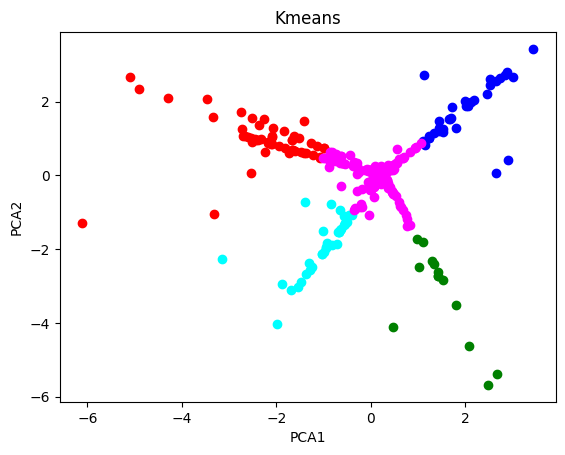

In [76]:

plt.scatter(X[y_kmeans==0, 0], X[y_kmeans==0, 1], c='red', label ='Cluster 1')
plt.scatter(X[y_kmeans==1, 0], X[y_kmeans==1, 1], c='blue', label ='Cluster 2')
plt.scatter(X[y_kmeans==2, 0], X[y_kmeans==2, 1], c='green', label ='Cluster 3')
plt.scatter(X[y_kmeans==3, 0], X[y_kmeans==3, 1], c='cyan', label ='Cluster 4')
plt.scatter(X[y_kmeans==4, 0], X[y_kmeans==4, 1], c='magenta', label ='Cluster 5')


plt.title('Kmeans')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()